In [4]:
__author__ = 'Hermen'
__status__ = 'Pending Validation'

"""
TO DO.
"""
from GM.graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import pandas as pd
import numpy as np

# To check naming, confusing with demand/prod + total not total
kg_to_1000tonnes = 1e-6
day_per_year = 365
ktonnes_to_hg = 1e7

FPi_nodes = {'FLOi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Food losses per food group'
},
    'FDKGi': {
    'type': 'input',
    'unit': 'kg/capita/day',
    'name': 'Kg food demand per day per food group'
},
    'SSRi': {
    'type': 'input',
    'unit': '1',
    'name': 'Self-sufficiency ratio per food group',
},
    'FDPi': {
    'type': 'variable',
    'unit': '1000 tonnes',
    'name': 'Total food production per food group',
    'computation': lambda FDKGi, Pop, FLOi, **kwargs: kg_to_1000tonnes * day_per_year * FDKGi * Pop * 1e3 + FLOi
},
    'OFi': {
    'type': 'variable',
    'unit': '1000 tonnes',
    'name': 'Other food demand',
    'computation': lambda SDi, NFDi, PDi, RDi, SVi, **kwargs: SDi + NFDi + PDi + RDi + SVi
},
    'SDi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Seed demand per food group'
},
    'NFDi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Non-food demand per food group'
},
    'PDi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Processed demand per food group'
},
    'RDi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Residual demand per food group'
},
    'SVi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Stock variation per food group'
},
    'FPi': {
    'type': 'output',
    'name': 'Food production per food group',
    'unit': '1000 tonnes',
    'computation': lambda SSRi, OFi, FDi, FDPi, **kwargs: (OFi + FDi + FDPi) * SSRi
},
    'FDi': {
    'type': 'input',
    'unit': '1000 tonnes',
    'name': 'Feed demand per food group'
},
    'Pop': {
    'type': 'input',
    'unit': '1000 persons',
    'name': 'Total population'
}
}

TCLDi_nodes = {'TCLDi': {
    'type': 'output',
    'name': 'Cropland demand',
    'unit': 'ha',
    'computation': lambda CYi, FPi, **kwargs: ktonnes_to_hg * FPi / CYi
},
    'CYi': {
    'type': 'input',
    'unit': 'hg/ha',
    'name': 'Crop yields per crop type'
},
    'FPi': {
    'type': 'input',
    'name': 'Food production per food group',
    'unit': '1000 tonnes'
},
}

CL_nodes = {'TCLDi': {
    'type': 'input',
    'name': 'Cropland demand',
    'unit': 'ha',
},
    'CL': {
    'type': 'output',
    'name': 'Cropland stock',
    'unit': '1000 ha',
    # Strange to check !
    'computation': lambda TCLDi, **kwargs: TCLDi.groupby(level=['ISO', 'Year']).sum() * 1e-2
},
}

IL_FL_nodes = {'CL': {
    'type': 'input',
    'name': 'Cropland stock',
    'unit': '1000 ha',
},
    'CL_baseline': {
    'type': 'input',
    'name': 'Cropland stock baseline',
    'unit': '1000 ha',
},
    'delta_CL': {
    'type': 'variable',
    'name': 'Change in cropland',
    'unit': '1000 ha',
    'computation': lambda CL, CL_baseline, **kwargs: CL - CL_baseline
},
    'IL_baseline': {
    'type': 'input',
    'unit': '1000 ha',
    'name': 'Inactive land baseline'
},
    'FL_baseline': {
    'type': 'input',
    'unit': '1000 ha',
    'name': 'Forest land baseline'
},
    'IL': {
    'type': 'output',
    'name': 'Inactive land stock',
    'unit': '1000 ha',
    # to double check
    'computation': lambda delta_CL, IL_baseline, **kwargs: (IL_baseline - delta_CL).clip(lower=0)
},
    'FL': {
    'type': 'output',
    'name': 'Forest land stock',
    'unit': '1000 ha',
    # to double check
    'computation': lambda delta_CL, FL_baseline, IL_baseline, **kwargs: FL_baseline + (IL_baseline - delta_CL).clip(upper=0)
}
}

BE2_nodes = {'TLA': {
    'type': 'input',
    'unit': '1000 ha',
    'name': 'Total land area'
},
    'FL': {
    'type': 'input',
    'unit': '1000 ha',
    'name': 'Forest land stock'
},
    'IL': {
    'type': 'input',
    'unit': '1000 ha',
    'name': 'Inactive land stock'
},
    'R_rate': {
    'type': 'parameter',
    'unit': '%',
    'name': 'Rate of reforestation'
},
    'FL_RF': {
    'type': 'variable',
    'name': 'Forest land stock after reforestation policy',
    'unit': '1000 ha',
    'computation': lambda FL, R_rate, IL, **kwargs: FL + 1e-2 * R_rate * IL
},
    'BE2': {
    'type': 'output',
    'name': 'Share of forest area to total land area',
    'unit': '%',
    'computation': lambda FL_RF, TLA, **kwargs: 1e2 * FL_RF / TLA
}
}


FPi_model = GraphModel(FPi_nodes)
TCLDi_partial_model = GraphModel(TCLDi_nodes)
TCLDi_model = GraphModel(concatenate_graph_specs([TCLDi_nodes, FPi_nodes]))
IL_FL_model = GraphModel(IL_FL_nodes)
BE2_partial_model = GraphModel(BE2_nodes)
BE2_model = GraphModel(concatenate_graph_specs(
    [BE2_nodes, IL_FL_nodes, CL_nodes, TCLDi_nodes, FPi_nodes]))

BE2_models = {
    'TCLDi_model': TCLDi_model,
    'TCLDi_partial_model': TCLDi_model,
    'FPi_model': FPi_model,
    'IL_FL_model': IL_FL_model,
    'BE2_partial_model': BE2_partial_model,
    'BE2_model': BE2_model
}


model_df = pd.read_csv('data/demo_data/BE2_data/BE2_df.csv')
landuse = pd.read_csv('data/demo_data/BE2_data/landuse.csv')


def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_(
    ) + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)

    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))

    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
]

data_dict = df_to_data_dict(model_df, itemized)


data_dict.update(df_to_data_dict(landuse, itemized=[]))

data_dict['CL_baseline'] = data_dict['CL']
data_dict['IL_baseline'] = data_dict['IL']
data_dict['FL_baseline'] = data_dict['FL']
data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)


def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values(
        'ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index)


def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(
        2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_percent_target_projection(series, percent_target=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values
    return series.interpolate()


def apply_itemized_percent_target_projection(series, percent_target=0):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = expand_series_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values

    return series.groupby(level=['ISO', 'Item']).apply(lambda group: group.interpolate())


def apply_annual_rate_projection(series, rate=1):
    series = series.copy()
    series = expand_series_non_itemized(series)

    year = series.loc[:, 2019:].index.get_level_values(level='Year').values

    series.loc[:, 2019:] = series.loc[:, 2018].values * rate ** (year - 2019)

    return series


def apply_constant_projection(series, constant=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2018:] = constant

    return series


def apply_itemized_ffill_projection(series):
    series = series.copy()
    series = expand_series_itemized(series)

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')


def apply_ffill_projection(series):
    series = series.copy()
    series = expand_series_non_itemized(series)

    return series.groupby(['ISO']).fillna(method='ffill')


def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)

    return results


def run_BE2_projection(data_dict):
    data_dict = data_dict.copy()
    
    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x),
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
     }
     
    
    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict



/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
ISO = 'FRA'

filtered_data_dict = {k: v.loc[ISO, 2000:] for k, v in data_dict.items()}


In [7]:
data_dict_extanded = run_BE2_projection(filtered_data_dict)

In [9]:
res = run_BE2_projection(data_dict_extanded)

In [10]:
res = run_BE2_scenario(data_dict=filtered_data_dict)


<AxesSubplot:xlabel='Year'>

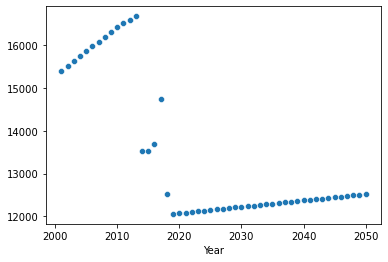

In [46]:
import seaborn as sns
sns.scatterplot(x=res['FL_RF'].index.get_level_values('Year'), y=res['FL_RF'])